In [1]:
import numpy as np
import scipy.linalg as sl
import scipy.integrate as si
import scipy.optimize
import matplotlib.pyplot as plt
from numba import njit


In [2]:
# our Fourier representation will use basis functions from n = -nmax to n = nmax
nmax = 128

# size of spatial domain
a = 16

In [3]:
# symmetric double well potential just for fun
#def v(x):
#    return 0.25*(x**2 - 25)**2

# dimensionless quantum harmonic oscillator potential
def v(x):
    return 0.5*x**2

In [4]:
# some sampling and FFT tricks
# this integer '100' can be adjusted to improve resolution
# if we set f_sample = 2*nmax, then we are sampling at the Nyquist frequency
f_sample = 100 * 2 * nmax
t, dt = np.linspace(-a, a, f_sample+2, endpoint=False, retstep=True)
y = (np.fft.rfft(v(t)) / t.size)[:(2*nmax+1)]

# this stores the Fourier series coefficients for n-m=0 to n-m=2*nmax
vrow = y * (-1)**np.arange(2*nmax+1)

# # if you want to use quadrature instead of the FFT:
# vraw = np.zeros(2*nmax+1, dtype=np.complex128)
# for thisn in range(2*nmax+1):
#     def integ(x):
#         return (2*a)**(-1)*np.exp(-1j*np.pi*thisn*x/a)*v(x)
#     def rinteg(x):
#         return np.real(integ(x))
#     def iinteg(x):
#         return np.imag(integ(x))
#     vraw[thisn] = si.quad(rinteg, a=-a, b=a)[0] + 1j*si.quad(iinteg, a=-a, b=a)[0]

# vrow = np.copy(vraw)

# create Toeplitz matrix
vmat = sl.toeplitz(r=vrow,c=np.conj(vrow))

# kinetic matrix
kmat = np.diag( np.arange(-nmax,nmax+1)**2 * np.pi**2 / (2*a**2) )

# Hamiltonian matrix 
hmat = kmat + vmat

# check whether Hamiltonian is Hermitian
print(np.linalg.norm( hmat - np.conj(hmat.T) ))

# eigendecomposition
spec, states = np.linalg.eigh(hmat)

# check whether this diagonalizes hmat
# note that if this is close to zero it means that
# hmat = states @ np.diag(spec) @ np.conj(states).T
print(np.linalg.norm( hmat @ states - states @ np.diag(spec) ))

# check whether we have a unitary matrix
print(np.linalg.norm( states @ np.conj(states).T - np.eye(2*nmax+1) ))

0.0
5.72003711317733e-12
4.07668687362199e-14


In [5]:
# find indices that sort eigenvalues
ordering = np.argsort(spec)

# spatial grid for the purposes of plotting
xvec = np.linspace(-a, a, 1025)

# convert basis coefficients into wavefunction on grid by matrix multiplication
nvec = np.arange(-nmax,nmax+1)
convmat = np.exp(1j*np.pi*np.outer(nvec, xvec)/a)/np.sqrt(2*a)

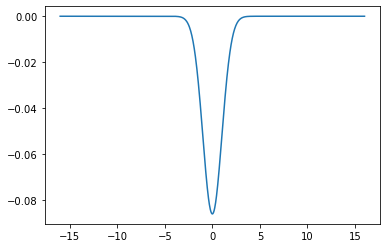

1.0000000000000018


In [6]:
# pick out and plot ground state
groundstate = ordering[0]
wavefn = states[:,groundstate] @ convmat
plt.plot(xvec, -np.real(wavefn))
plt.show()

# check normalization
print(np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])))

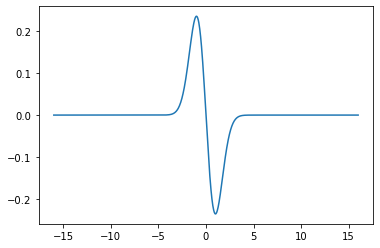

0.9999999999999993


In [7]:
# pick out and plot j-th state with j starting at 0
wavefn = states[:,ordering[1]] @ convmat
plt.plot(xvec, np.imag(wavefn))
plt.show()

# check normalization
print(np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])))

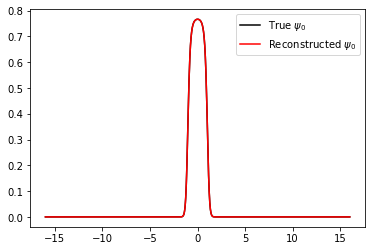

In [8]:
# triangular pulse
# def psi0(x):
#     return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])

# parabolic pulse
# def psi0(x):
#     return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])

# hyperbolic secant squared
# def psi0(x):
#     return (np.cosh(x))**(-2)

# Laplace
# def psi0(x):
#     return np.exp(-np.abs(x))

# rounded box function
def psi0(x):
    return 1.0 + np.tanh((1 - x**2)/0.5)

# normalize psi0
norm = np.sqrt(si.quad(lambda x: np.abs(psi0(x))**2, a=-1, b=a)[0])
def normpsi0(x):
    return psi0(x)/norm

# transform initialize wave function to a0
vraw = np.zeros(nmax+1, dtype=np.complex128)
for thisn in range(nmax+1):
    def integ(x):
        return (2*a)**(-0.5)*np.exp(-1j*np.pi*thisn*x/a)*normpsi0(x)
    def rinteg(x):
        return np.real(integ(x))
    def iinteg(x):
        return np.imag(integ(x))
    vraw[thisn] = si.quad(rinteg, a=-a, b=a)[0] + 1j*si.quad(iinteg, a=-a, b=a)[0]
# ainit = a0
ainit = np.concatenate([np.conjugate(np.flipud(vraw[1:])), vraw])

# # some sampling and FFT tricks
# # this integer '100' can be adjusted to improve resolution
# # if we set f_sample = 2*nmax, then we are sampling at the Nyquist frequency
# f_sample = 100 * 2 * nmax
# t, dt = np.linspace(-a, a, f_sample+2, endpoint=False, retstep=True)
# y = (np.fft.rfft(psi0(t)) / t.size)[:(2*nmax+1)]

# # this stores the Fourier series coefficients for n-m=0 to n-m=2*nmax
# vraw = y * (-1)**np.arange(2*nmax+1) * np.sqrt(2*a)
# vrow2 = np.concatenate([np.flipud(vraw[nmax+1:]), vraw[:nmax+1]])

# check whether psi0 is represented OK
plt.plot(xvec, normpsi0(xvec), color='black', label=r"True $\psi_0$")
psi0recon = np.real(ainit @ convmat)
plt.plot(xvec, psi0recon, color='red', label=r"Reconstructed $\psi_0$")
plt.legend()
plt.show()

In [9]:
# set the time step and compute the propagator matrix
# note that we are reusing the spec, states eigendecomposition of hmat computed above
dt = 0.01
prop = states @ np.diag(np.exp(-1j*spec*dt)) @ np.conj(states.T)

In [10]:
# propagate the "a" vector of coefficients as defined above
nsteps = 200
amat = np.zeros((nsteps+1, 2*nmax+1), dtype=np.complex128)
amat[0,:] = np.copy(ainit)
for j in range(nsteps):
    amat[j+1,:] = prop @ amat[j,:]

# compute the wave function in space from each "a" vector
# do it all at once using matrix multiplication!
psi2 = (np.abs(amat @ convmat))**2

# compute norm of wave function?
psinorm = np.sqrt(np.sum(np.abs(amat)**2, axis=1))
print(psinorm)

[1.00681842 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842
 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842
 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842
 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842
 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842
 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842
 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842
 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842
 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842
 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842
 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842
 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842
 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842
 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842
 1.00681842 1.00681842 1.00681842 1.00681842 1.00681842 1.0068

In [11]:
Xind, Yind = np.meshgrid(np.arange(2*(2*nmax+1)-1),np.arange(2*(2*nmax+1)-1))
indices = np.stack([Xind.flatten(), Yind.flatten()]).T
print(indices.shape)

# # from itertools import product
# # indices2 = np.flip(np.array(list(product(np.arange(2*(2*nmax+1)-1), np.arange(2*(2*nmax+1)-1)))),1)

# pools = [list(np.arange(2*(2*nmax+1)-1)) for i in range(2)]
# result = [[]]
# for pool in pools:
#     result = [x+[y] for x in result for y in pool]
# indices3 = np.flip(np.array(result),1)

# print(np.linalg.norm(indices-indices3))


(263169, 2)


In [12]:
# this function implements the adjoint method described mathematically above
# it takes as input x, which is a concatenation of the real and imaginary parts of thetahat
# as you can see from the first 5 lines of the function, 
# the real and imaginary part of thetahat *parameterize* the potential matrix "vhatmat"
# @jit(nopython=True)
@njit
def toeplitz(r, c):
    c = np.asarray(c).ravel()
    r = np.asarray(r).ravel()
    # Form a 1-D array containing a reversed c followed by r[1:] that could be
    # strided to give us toeplitz matrix.
    vals = np.concatenate((c[::-1], r[1:]))
    out_shp = len(c), len(r)
    n = vals.strides[0]
    return np.lib.stride_tricks.as_strided(vals[len(c)-1:], shape=out_shp, strides=(-n, n)).copy()

# @jit(nopython=True)
@njit
def fone(di, dk, dn, aik, akn):
    return -aik*akn*((dn-dk)*np.exp(di) + (di-dn)*np.exp(dk) + (dk-di)*np.exp(dn))/((di-dk)*(di-dn)*(dk-dn))

# @jit(nopython=True)
@njit
def fik(di, dn, aik, akn):
    return aik*akn*((-1.0 + di - dn)*np.exp(di) + np.exp(dn))/((di-dn)**2)

# @jit(nopython=True)
@njit
def fin(di, dk, aik, akn):
    return aik*akn*((-1.0 + di - dk)*np.exp(di) + np.exp(dk))/((di-dk)**2)

# @jit(nopython=True)
@njit
def fkn(di, dk, aik, akn):
    return -aik*akn*(-np.exp(di) + (1.0 + di - dk)*np.exp(dk))/((di-dk)**2)

# @jit(nopython=True)
@njit
def fikn(di, aik, akn):
    return 0.5*aik*akn*np.exp(di)

# @jit(nopython=True)
@njit
def adjhesshelper(x):
    m = 2*nmax + 1
    thetahatR = x[:m]
    thetahatI = np.copy(x[(m-1):])
    thetahatI[0] = 0.0
    thetahat = thetahatR + 1j*thetahatI
    vhatmat = toeplitz(r=thetahat,c=np.conj(thetahat))
    
    # Hamiltonian matrix 
    hhatmat = kmat + vhatmat
    
    # eigendecomposition and compute propagator
    hatspec, hatstates = np.linalg.eigh(hhatmat)
    hatprop = hatstates @ np.diag(np.exp(-1j*hatspec*dt)) @ np.conj(hatstates.T)
    hatpropH = hatstates @ np.diag(np.exp(1j*hatspec*dt)) @ np.conj(hatstates.T)
    
    # propagate the "a" vector of coefficients forward in time
    # in other words, solve the *forward* problem
    ahatmat = np.zeros((nsteps+1, 2*nmax+1), dtype=np.complex128)
    ahatmat[0,:] = np.copy(ainit)
    for j in range(nsteps):
        ahatmat[j+1,:] = hatprop @ ahatmat[j,:]
    
    # propagate the "lambda" vector of coefficients backward in time
    # in other words, solve the *adjoint* problem
    lambmat = np.zeros((nsteps+1, 2*nmax+1), dtype=np.complex128)
    lambmat[nsteps,:] = ahatmat[nsteps,:] - amat[nsteps,:] 
    for j in range(nsteps-1,0,-1):
        lambmat[j,:] = ahatmat[j,:] - amat[j,:] + hatpropH @ lambmat[j+1,:] 
    
    # Compute the gradients
    # Most of this stuff is math that computes the directional derivative of the matrix exponential,
    # the part of the derivation above where we see "\partial \exp(Z) / \partial Z \cdot A"
    # for some matrix A.
    # All of this code has been checked against JAX autograd to make sure it is computing gradients correctly.
    # Note that it is much faster than JAX autograd.
    alldmat = np.zeros((2*m-1, m, m), dtype=np.complex128)
    expspec = np.exp(-1j*dt*hatspec)
    mask = np.zeros((m,m), dtype=np.complex128)
    for ii in range(m):
        for jj in range(m):
            if np.abs(hatspec[ii] - hatspec[jj]) < 1e-8:
                mask[ii,ii] = expspec[ii]
            else:
                mask[ii,jj] = (expspec[ii] - expspec[jj])/(-1j*dt*(hatspec[ii]-hatspec[jj]))
    
    derivamat = np.zeros((2*m-1, m, m), dtype=np.complex128)
    for iii in range(m):
        ctrvec = np.zeros(m, dtype=np.complex128)
        ctrvec[iii] = 1.0
        ctrmat = toeplitz(r=ctrvec, c=np.conj(ctrvec))
        derivamat[iii, :, :] = hatstates.conj().T @ ctrmat @ hatstates
        qmat = derivamat[iii, :, :] * mask
        alldmat[iii,:,:] = -1j*dt* hatstates @ qmat @ hatstates.conj().T
    
    for iii in range(m-1):
        ctrvec = np.zeros(m, dtype=np.complex128)
        ctrvec[iii + 1] = 1.0j
        ctrmat = toeplitz(r=ctrvec, c=np.conj(ctrvec))
        derivamat[m + iii, :, :] = hatstates.conj().T @ ctrmat @ hatstates
        qmat = derivamat[m + iii, :, :] * mask
        alldmat[m + iii,:,:] = -1j*dt* hatstates @ qmat @ hatstates.conj().T
    
    #ddmat = np.zeros((2*m-1,2*m-1,m,m), dtype=np.complex128)
    hsp = -1j*dt*hatspec
    thishess = np.zeros((2*m-1,2*m-1,m,m), dtype=np.complex128)
    for ii in range(m):
        for nn in range(m):
            result = np.zeros((2*m-1)**2, dtype=np.complex128)
            for kk in range(m):
                if ii==nn:
                    if kk==nn:
                        result += fikn(hsp[ii], derivamat[indices[:,0],ii,kk], derivamat[indices[:,1],kk,nn])
                        result += fikn(hsp[ii], derivamat[indices[:,1],ii,kk], derivamat[indices[:,0],kk,nn])
                    else:
                        result += fin(hsp[ii], hsp[kk], derivamat[indices[:,0],ii,kk], derivamat[indices[:,1],kk,nn])
                        result += fin(hsp[ii], hsp[kk], derivamat[indices[:,1],ii,kk], derivamat[indices[:,0],kk,nn])
                elif kk==nn:
                    result += fkn(hsp[ii], hsp[kk], derivamat[indices[:,0],ii,kk], derivamat[indices[:,1],kk,nn])
                    result += fkn(hsp[ii], hsp[kk], derivamat[indices[:,1],ii,kk], derivamat[indices[:,0],kk,nn])
                elif ii==kk:
                    result += fik(hsp[ii], hsp[nn], derivamat[indices[:,0],ii,kk], derivamat[indices[:,1],kk,nn])
                    result += fik(hsp[ii], hsp[nn], derivamat[indices[:,1],ii,kk], derivamat[indices[:,0],kk,nn])
                else:
                    result += fone(hsp[ii], hsp[kk], hsp[nn], derivamat[indices[:,0],ii,kk], derivamat[indices[:,1],kk,nn])
                    result += fone(hsp[ii], hsp[kk], hsp[nn], derivamat[indices[:,1],ii,kk], derivamat[indices[:,0],kk,nn])
                thishess[:,:,ii,nn] += result #.reshape((2*m-1,2*m-1))
    
    return lambmat, alldmat, ahatmat, hatspec, hatstates, thishess

In [13]:
def adjhess(x):
    ddmat = np.zeros((2*m-1,2*m-1,m,m), dtype=np.complex128)
    
    lambmat, alldmat, ahatmat, hatspec, hatstates, thishess = adjhesshelper(x)
    
    # compute lagrangian
    resid = ahatmat - amat
    lag = 0.5*np.real(np.sum(np.conj(resid)*resid))
    
    # compute all entries of the gradient at once
    gradients = np.real(np.einsum('ij,ajk,ik->a', np.conj(lambmat[1:,:]), alldmat, ahatmat[:-1,:]))
    
    # propagate \nabla_{\theta} a
    hatprop = hatstates @ np.diag(np.exp(-1j*hatspec*dt)) @ np.conj(hatstates.T)
    hatpropH = hatstates @ np.diag(np.exp(1j*hatspec*dt)) @ np.conj(hatstates.T)
    gradamat = np.zeros((nsteps+1, 2*nmax+1, 4*nmax+1), dtype=np.complex128)
    for j in range(nsteps):
        gradamat[j+1,:,:] = hatprop @ gradamat[j,:,:] + (alldmat @ ahatmat[j,:]).T
    
    # propagate \nabla_{\theta} \lambda
    gradlamb = np.zeros((nsteps+1, 2*nmax+1, 4*nmax+1), dtype=np.complex128)
    gradlamb[nsteps] = np.copy(gradamat[nsteps])
    alldmatH = np.transpose(alldmat.conj(),axes=(2,1,0))
    for j in range(nsteps-1,-1,-1):
        term1 = hatpropH @ gradlamb[j+1,:,:]
        term2 = np.einsum('ijk,j->ik', alldmatH, lambmat[j+1,:])
        gradlamb[j,:,:] = gradamat[j,:,:] + term1 + term2
    
    # compute all entries of the Hessian at once
    ddmat = (-dt**2)*np.einsum('ij,abjk,kl->abil',hatstates,thishess,hatstates.conj().T)
    hesspt1 = np.real(np.einsum('ijl,ajk,ik->al', np.conj(gradlamb[1:,:,:]), alldmat, ahatmat[:-1,:]))
    hesspt2 = np.real(np.einsum('ij,ajk,ikl->al', np.conj(lambmat[1:,:]), alldmat, gradamat[:-1,:,:]))
    hesspt3 = np.real(np.einsum('ij,aljk,ik->al', np.conj(lambmat[1:,:]), ddmat, ahatmat[:-1,:]))
    hess = hesspt1 + hesspt2 + hesspt3
    
    return lag, gradients, hess

In [14]:
# grab true theta used to generate training data
truethetaR = np.real(vrow)
truethetaI = np.imag(vrow[1:])
x0 = np.concatenate([truethetaR, truethetaI])
print(x0.shape)

(513,)


In [ ]:
# compute Lagrangian and gradient for true theta
truelag, trueag, truehess = adjhess(x0)

# think of this as a sanity check: when we plug in the true theta,
# - the Lagrangian should be zero, because the objective function should be 0 and the constraint is satisfied, and
# - the gradient of the Lagrangian should be zero
print(truelag)
print(np.linalg.norm(trueag))

In [16]:
# for the purposes of calling scipy.optimize, we split our adjgrad function into two parts

# this function computes the Lagrangian; it *does not compute* the gradient
@jit(nopython=True)
def justlag(x):
    m = 2*nmax + 1
    thetahatR = x[:m]
    thetahatI = np.copy(x[(m-1):])
    thetahatI[0] = 0.0
    thetahat = thetahatR + 1j*thetahatI
    vhatmat = toeplitz(r=thetahat,c=np.conj(thetahat))
    
    # Hamiltonian matrix 
    hhatmat = kmat + vhatmat
    
    # eigendecomposition and compute propagator
    hatspec, hatstates = np.linalg.eigh(hhatmat)
    hatprop = hatstates @ np.diag(np.exp(-1j*hatspec*dt)) @ np.conj(hatstates.T)
    hatpropH = hatstates @ np.diag(np.exp(1j*hatspec*dt)) @ np.conj(hatstates.T)
    
    # propagate the "a" vector of coefficients as defined above
    ahatmat = np.zeros((nsteps+1, 2*nmax+1), dtype=np.complex128)
    ahatmat[0,:] = np.copy(ainit)
    for j in range(nsteps):
        ahatmat[j+1,:] = hatprop @ ahatmat[j,:]
    
    # compute lagrangian
    resid = ahatmat - amat
    lag = 0.5*np.real(np.sum(np.conj(resid)*resid))
    
    return lag

def justgrad(x):
    lambmat, alldmat, ahatmat, _, _, _ = adjhesshelper(x)
    
    # compute all entries of the gradient at once
    gradients = np.real(np.einsum('ij,ajk,ik->a', np.conj(lambmat[1:,:]), alldmat, ahatmat[:-1,:]))
    return gradients

def justhess(x):
    lambmat, alldmat, ahatmat, hatspec, hatstates, thishess = adjhesshelper(x)
    
    # propagate \nabla_{\theta} a
    hatprop = hatstates @ np.diag(np.exp(-1j*hatspec*dt)) @ np.conj(hatstates.T)
    hatpropH = hatstates @ np.diag(np.exp(1j*hatspec*dt)) @ np.conj(hatstates.T)
    gradamat = np.zeros((nsteps+1, 2*nmax+1, 4*nmax+1), dtype=np.complex128)
    for j in range(nsteps):
        gradamat[j+1,:,:] = hatprop @ gradamat[j,:,:] + (alldmat @ ahatmat[j,:]).T
    
    # propagate \nabla_{\theta} \lambda
    gradlamb = np.zeros((nsteps+1, 2*nmax+1, 4*nmax+1), dtype=np.complex128)
    gradlamb[nsteps] = np.copy(gradamat[nsteps])
    alldmatH = np.transpose(alldmat.conj(),axes=(2,1,0))
    for j in range(nsteps-1,-1,-1):
        term1 = hatpropH @ gradlamb[j+1,:,:]
        term2 = np.einsum('ijk,j->ik', alldmatH, lambmat[j+1,:])
        gradlamb[j,:,:] = gradamat[j,:,:] + term1 + term2
    
    # compute all entries of the Hessian at once
    ddmat = (-dt**2)*np.einsum('ij,abjk,kl->abil',hatstates,thishess,hatstates.conj().T)
    hesspt1 = np.real(np.einsum('ijl,ajk,ik->al', np.conj(gradlamb[1:,:,:]), alldmat, ahatmat[:-1,:]))
    hesspt2 = np.real(np.einsum('ij,ajk,ikl->al', np.conj(lambmat[1:,:]), alldmat, gradamat[:-1,:,:]))
    hesspt3 = np.real(np.einsum('ij,aljk,ik->al', np.conj(lambmat[1:,:]), ddmat, ahatmat[:-1,:]))
    hess = hesspt1 + hesspt2 + hesspt3
    return hess

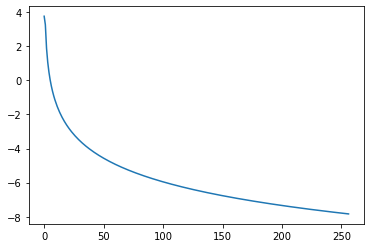

In [20]:
plt.plot(np.arange(2*nmax+1),np.log(np.abs(truethetaR)))
plt.show()

In [21]:
2366*np.exp(-0.4*np.arange(2*nmax+1))*((-1)**np.arange(2*nmax+1))

array([ 2.36600000e+03, -1.58597723e+03,  1.06311233e+03, -7.12625505e+02,
        4.77687162e+02, -3.20203280e+02,  2.14638677e+02, -1.43876608e+02,
        9.64433746e+01, -6.46479273e+01,  4.33348016e+01, -2.90481862e+01,
        1.94715815e+01, -1.30521914e+01,  8.74914555e+00, -5.86472765e+00,
        3.93124451e+00, -2.63519200e+00,  1.76642202e+00, -1.18406809e+00,
        7.93704578e-01, -5.32036089e-01,  3.56634456e-01, -2.39059225e-01,
        1.60246191e-01, -1.07416234e-01,  7.20032548e-02, -4.82652251e-02,
        3.23531479e-02, -2.16869636e-02,  1.45372064e-02, -9.74458088e-03,
        6.53198791e-03, -4.37852243e-03,  2.93501136e-03, -1.96739695e-03,
        1.31878561e-03, -8.84008433e-04,  5.92568574e-04, -3.97210594e-04,
        2.66258223e-04, -1.78478225e-04,  1.19637532e-04, -8.01954358e-05,
        5.37566082e-05, -3.60341321e-05,  2.41544011e-05, -1.61911792e-05,
        1.08532720e-05, -7.27516580e-06,  4.87668947e-06, -3.26894271e-06,
        2.19123783e-06, -

In [22]:
truethetaR

array([ 4.26666668e+01, -2.59382231e+01,  6.48455588e+00, -2.88202491e+00,
        1.62113907e+00, -1.03752905e+00,  7.20506325e-01, -5.29351620e-01,
        4.05284865e-01, -3.20225106e-01,  2.59382360e-01, -2.14365610e-01,
        1.80126679e-01, -1.53480740e-01,  1.32338003e-01, -1.15281121e-01,
        1.01321314e-01, -8.97517669e-02,  8.00563741e-02, -7.18511635e-02,
        6.48456877e-02, -5.88169624e-02,  5.35915000e-02, -4.90326879e-02,
        4.50317674e-02, -4.15012870e-02,  3.83702826e-02, -3.55806830e-02,
        3.30845983e-02, -3.08422503e-02,  2.88203780e-02, -2.69909970e-02,
        2.53304261e-02, -2.38185168e-02,  2.24380394e-02, -2.11741898e-02,
        2.00141912e-02, -1.89469695e-02,  1.79628885e-02, -1.70535312e-02,
        1.62115196e-02, -1.54303640e-02,  1.47043382e-02, -1.40283741e-02,
        1.33979727e-02, -1.28091292e-02,  1.22582696e-02, -1.17421958e-02,
        1.12580395e-02, -1.08032218e-02,  1.03754194e-02, -9.97253427e-03,
        9.59266829e-03, -

In [23]:
# as an easy test case, let us take the true theta and perturb it
# with random normally distributed noise (with small variance)
# the optimizer should not have great difficulty converging to a good minimum
# starting from here

x0 = np.concatenate([truethetaR, truethetaI])
x0 += 0.25*np.random.normal(size=x0.shape)

# minlag = np.Inf
# for j in range(5000):
#     x0 = np.zeros((4*nmax+1))
#     amp = np.random.normal()*2000
#     decay = np.random.uniform()
#     x0[:(2*nmax+1)] = amp*np.exp(-decay*np.arange(2*nmax+1)**(0.5))*((-1)**np.arange(2*nmax+1))
#     thislag = justlag(x0)
#     if thislag < minlag:
#         minlag = thislag
#         goodx0 = np.copy(x0)
        
# print(minlag)
# print(np.linalg.norm(x0[:(2*nmax+1)] - truethetaR))

In [ ]:
# itx = np.copy(goodx0)
# ind = 0
# lr = 1e-3
# for i in range(100):
#     nab = justgrad(itx)
#     itx[ind] -= lr*nab[ind]
#     print(justlag(itx))
#     ind += 1
#     if ind==itx.shape[0]:
#         ind = 0

In [ ]:
res = scipy.optimize.minimize(justlag, x0, method='trust-constr', hess=justhess, jac=justgrad, 
                              options={'verbose': 3, 'maxiter': 1000}) 

In [ ]:
import pickle

In [ ]:
with open('result.pickle', 'wb') as handle:
    pickle.dump(res, handle)

In [ ]:
np.savez('resx.npz',res.x)

In [ ]:
# print out the value of the Lagrangian at the thetahat found by the optimizer
print(justlag(res.x))

# has the optimizer found a thetahat that is close to the true theta?
print(np.linalg.norm(res.x - np.concatenate([truethetaR, truethetaI])))

In [ ]:
# plot the estimated potential
mm = 2*nmax+1
thetahat = np.zeros(mm, dtype=np.complex128)
thetahat += res.x[:mm]
thetahat[1:] += 1j*res.x[mm:]
nvec2 = np.arange(-2*nmax,2*nmax+1)
convmat2 = np.exp(1j*np.pi*np.outer(nvec2, xvec)/a)
fullthetahat = np.concatenate([np.flipud(thetahat[1:].conj()), thetahat])
vx = fullthetahat @ convmat2

# real part
# red = learned potential
# black = true potential
trim = 250
plt.plot(xvec[trim:-trim], np.real(vx)[trim:-trim], color='red')
plt.plot(xvec[trim:-trim], np.real(v(xvec))[trim:-trim], color='black')
plt.xlabel('x')
plt.ylabel('Re(v(x))')
plt.savefig('adjrecon.pdf')
plt.show()

In [ ]:
# real part
# red = learned potential
# black = true potential
trim = 250
plt.plot(xvec[trim:-trim], np.real(vx)[trim:-trim] - np.real(v(xvec))[trim:-trim], color='black')
plt.xlabel('x')
plt.ylabel('difference in real parts')
plt.show()

In [ ]:
truethetavec = np.concatenate([truethetaR, truethetaI])
plt.plot( (truethetavec - res.x) / np.linalg.norm( truethetavec ) )
plt.show()

In [ ]:
# imaginary part
# red = learned potential
# black = true potential
plt.plot(xvec, np.imag(vx), color='red')
plt.plot(xvec, np.imag(v(xvec)), color='black')
plt.xlabel('x')
plt.ylabel('Im(v(x))')
plt.show()

In [ ]:
# start from uniform random initial condition (uniform on [-0.5, 0.5])
# should be difficult for optimizer to find a good minimum starting from here,
# so this is a great test case to prove the method works well
thetahatR = np.random.uniform(size=2*nmax+1) - 0.5
thetahatI = np.random.uniform(size=2*nmax) - 0.5
x0 = np.concatenate([thetahatR, thetahatI])
res = scipy.optimize.minimize(justlag, x0, method='bfgs', jac=justgrad, 
                              options={'gtol':1e-10, 'iprint':99, 'disp': True})

In [ ]:
# plot the estimated potential
# so far, this does not look so great

mm = 2*nmax+1
thetahat = np.zeros(mm, dtype=np.complex128)
thetahat += res.x[:mm]
thetahat[1:] += 1j*res.x[mm:]
nvec2 = np.arange(-2*nmax,2*nmax+1)
convmat2 = np.exp(1j*np.pi*np.outer(nvec2, xvec)/a)
fullthetahat = np.concatenate([np.flipud(thetahat[1:].conj()), thetahat])
vx = fullthetahat @ convmat2

# real part
# red = learned potential
# black = true potential
plt.plot(xvec, np.real(vx), color='red')
plt.plot(xvec, np.real(v(xvec)), color='black')
plt.xlabel('x')
plt.ylabel('Re(v(x))')
plt.show()